# 03 - FLAML 优化技巧

> 🎯 学习目标：掌握微软FLAML的快速优化能力，理解成本敏感的超参数调优

---

## 📚 本节内容

1. FLAML 简介与核心优势
2. 快速上手
3. 成本敏感优化
4. 大数据集优化
5. 与其他AutoML工具对比
6. 高级配置

---

## ⚡ 为什么选择 FLAML？

**FLAML = Fast and Lightweight AutoML**

### 核心优势

1. **速度最快** ⚡
   - 比传统AutoML快10-100倍
   - 低计算成本

2. **资源高效** 💰
   - 成本敏感的优化算法
   - 适合预算有限的场景

3. **大数据友好** 📈
   - 支持大规模数据集
   - 增量学习

4. **工业级** 🏢
   - 微软内部大规模使用
   - 生产环境验证

---

## 1. 安装与导入

In [ ]:
# ==================== 1. 安装与导入 ====================
#
# 📦 FLAML 依赖说明:
#
# FLAML (Fast and Lightweight AutoML) 是微软开发的 AutoML 库
# 主要依赖:
# - flaml: 核心 AutoML 库
# - numpy: 数值计算库
# - pandas: 数据处理库
# - matplotlib/seaborn: 数据可视化
# - sklearn: 机器学习算法库,数据集和评估指标
#
# 💡 安装命令:
# pip install flaml
#
# 推荐版本: flaml>=1.0.0
# 兼容性: Python 3.7+
#
# 📚 导入的库说明:
# - numpy/pandas: 用于数据处理和矩阵运算
# - matplotlib/seaborn: 用于绘制可视化图表
# - time: 用于计时,对比不同方法的速度
# - sklearn: 提供数据集和评估指标

# 安装 FLAML
# !pip install flaml

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.datasets import load_iris, load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss

print("✅ 基础库导入成功")

---

## 🧠 FLAML 核心原理: CFO 算法深度讲解

> 💡 **为什么要学习 CFO 算法?**
>
> 理解 CFO (Cost-Frugal Optimization) 是掌握 FLAML 的关键!
> 它解释了为什么 FLAML 比传统 AutoML 更快、更省资源。

### 1. 传统超参数优化的问题

**网格搜索 (Grid Search)**:
- ❌ 遍历所有参数组合,计算量随参数数量指数增长
- ❌ 不考虑训练成本,浪费时间在低效配置上
- ❌ 无法处理连续参数空间

**随机搜索 (Random Search)**:
- ⚠️ 随机采样,缺乏智能引导
- ⚠️ 可能错过最优配置
- ⚠️ 仍然不考虑训练成本

**贝叶斯优化 (Bayesian Optimization)**:
- ✅ 智能搜索,利用历史信息
- ❌ 建立代理模型本身开销大
- ❌ 不适合大规模参数空间

---

### 2. CFO 的核心创新: 成本敏感优化

**CFO 的关键思想**:
```
不仅关注"性能",还关注"成本"!

传统优化: 找最高性能的配置
CFO优化: 找性价比最高的配置

性价比 = 性能提升 / 训练成本
```

**三大核心机制**:

1. **低成本优先**: 优先尝试训练快的配置
2. **早停策略**: 如果某配置明显不行,提前终止
3. **动态资源分配**: 根据已有结果,智能分配剩余时间

---

### 3. CFO 工作流程 (伪代码演示)

```python
def CFO_search(time_budget, estimators, param_spaces):
    """
    CFO 算法简化版伪代码
    
    参数:
        time_budget: 总时间预算 (秒)
        estimators: 候选模型列表 ['xgboost', 'rf', 'lgbm', ...]
        param_spaces: 每个模型的超参数空间
    
    返回:
        best_model, best_config, best_score
    """
    
    # 初始化
    results = []           # 存储所有尝试的结果
    spent_time = 0        # 已花费时间
    
    # ========== 阶段1: 低成本探索 ==========
    # 每个模型先用最小成本配置快速验证
    for estimator in estimators:
        # 获取该模型的低成本配置 (如:小n_estimators, 浅树)
        config = get_low_cost_config(estimator, param_spaces[estimator])
        
        # 训练并评估
        score, cost = train_and_evaluate(estimator, config, X_train, y_train)
        
        # 记录结果
        results.append({
            'estimator': estimator,
            'config': config,
            'score': score,
            'cost': cost
        })
        
        spent_time += cost
        
        if spent_time >= time_budget:
            break
    
    # ========== 阶段2: 智能深化搜索 ==========
    # 根据"性价比"选择配置继续优化
    while spent_time < time_budget:
        # 计算每个配置的"潜力" (性价比)
        # 潜力 = (可能的性能提升) / (预期训练成本)
        next_config = select_by_cost_frugality(results, param_spaces)
        
        # 如果找不到有潜力的配置,提前结束 (早停)
        if next_config is None:
            break
        
        # 训练新配置
        score, cost = train_and_evaluate(
            next_config['estimator'],
            next_config['config'],
            X_train,
            y_train
        )
        
        # 记录结果
        results.append({
            'estimator': next_config['estimator'],
            'config': next_config['config'],
            'score': score,
            'cost': cost
        })
        
        spent_time += cost
    
    # 返回最佳结果
    best_result = max(results, key=lambda x: x['score'])
    return best_result['estimator'], best_result['config'], best_result['score']


def select_by_cost_frugality(results, param_spaces):
    """
    CFO 的核心: 选择性价比最高的下一个配置
    
    考虑因素:
    1. 当前最佳模型还有提升空间吗?
    2. 尝试新模型的成本是否值得?
    3. 调整哪个超参数能带来最大性价比?
    """
    # 简化版逻辑:
    # - 如果当前最佳模型还有很大参数空间未探索 → 继续深化
    # - 如果当前最佳已接近上限 → 尝试其他模型
    # - 优先调整影响大、成本低的参数 (如 learning_rate)
    
    # 这里省略具体实现...
    pass
```

---

### 4. CFO vs 其他算法对比

| 算法 | 搜索策略 | 是否考虑成本 | 适用场景 | 速度 |
|------|---------|------------|---------|------|
| **网格搜索** | 遍历所有组合 | ❌ | 小参数空间 | ⭐ 很慢 |
| **随机搜索** | 随机采样 | ❌ | 中等参数空间 | ⭐⭐⭐ 中等 |
| **贝叶斯优化** | 高斯过程引导 | ❌ | 连续参数 | ⭐⭐⭐ 中等 |
| **CFO (FLAML)** | 成本敏感搜索 | ✅ | 大参数空间 | ⭐⭐⭐⭐⭐ 很快 |

**CFO 的优势**:
- ✅ 在有限时间内找到更好的配置
- ✅ 自动平衡"探索"和"利用"
- ✅ 适应不同的时间预算 (从 30秒 到 1小时)
- ✅ 不需要手动调整搜索策略

---

### 5. 直观理解: CFO 的搜索过程

想象你在餐厅点菜,预算有限:

**网格搜索**: 把菜单上每道菜都点一遍 → 太贵!  
**随机搜索**: 闭眼随机点几道菜 → 可能很难吃!  
**贝叶斯优化**: 点几道菜,推测其他菜的口味 → 推测本身很费时!  
**CFO**: 先点便宜的菜试试口味,再根据性价比决定要不要点贵的 → 聪明!

**CFO 的策略**:
1. 先点便宜菜快速了解餐厅水平
2. 如果便宜菜很好吃,加点贵一点的同类菜
3. 如果便宜菜很难吃,立即换其他类型
4. 持续优化,直到预算用完

---

### 6. 实际效果对比 (理论预测)

假设在 60 秒时间预算下:

| 方法 | 尝试配置数 | 最佳准确率 | 耗时 |
|------|-----------|----------|------|
| 网格搜索 | ~10 | 0.92 | 60s (用完) |
| 随机搜索 | ~15 | 0.94 | 60s (用完) |
| 贝叶斯优化 | ~12 | 0.95 | 60s (用完) |
| **CFO (FLAML)** | **~30** | **0.96** | **45s (早停)** |

**CFO 为什么更快?**
- 低成本配置训练快 (如 10棵树 vs 1000棵树)
- 早停避免浪费时间
- 智能跳过明显不行的配置

---

💡 **接下来**: 我们将在实际案例中观察 CFO 的工作过程!

---

## 2. 快速上手：分类任务

### 2.1 加载数据

In [9]:
# ==================== 2.1 加载数据 ====================
#
# 📚 乳腺癌数据集 (Breast Cancer Wisconsin Dataset)
#
# 数据集简介:
# - 来源: UCI Machine Learning Repository
# - 样本数: 569 (良性 357, 恶性 212)
# - 特征数: 30 (均为数值型)
# - 任务类型: 二分类 (良性 vs 恶性)
#
# 特征类型:
# - 细胞核特征的统计量,包括:
#   * 半径 (radius)
#   * 纹理 (texture)
#   * 周长 (perimeter)
#   * 面积 (area)
#   * 平滑度 (smoothness)
#   * 紧密度 (compactness)
#   * 凹陷度 (concavity)
#   * 凹点数 (concave points)
#   * 对称性 (symmetry)
#   * 分形维数 (fractal dimension)
# - 每种特征有 3 个版本: mean, SE (标准误差), worst (最坏情况)
#
# 💡 为什么选择这个数据集?
# 1. 真实医疗数据,有实际应用价值
# 2. 二分类任务,适合演示 AutoML 的分类能力
# 3. 特征数量适中 (30个),适合分析特征重要性
# 4. 数据质量高,无缺失值,适合教学演示
# 5. 样本量适中 (569个),训练速度快,适合快速实验
#
# 🎯 学习目标:
# - 理解如何加载和划分数据
# - 了解数据集的基本特征
# - 为后续的 AutoML 训练做准备

# 加载乳腺癌数据集
X, y = load_breast_cancer(return_X_y=True)

# 划分训练集和测试集
# - test_size=0.2: 80% 训练, 20% 测试
# - random_state=42: 随机种子,保证结果可复现
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"训练集形状: {X_train.shape}")
print(f"测试集形状: {X_test.shape}")

训练集形状: (455, 30)
测试集形状: (114, 30)


### 2.2 使用 FLAML（最简单的方式）

In [10]:
# ==================== 2.2 使用 FLAML 训练模型 ====================
#
# 📚 automl.fit() 函数详解
#
# 这是 FLAML 的核心函数,会自动完成:
# 1. **模型选择**: 从多个候选模型中选择 (XGBoost、LightGBM、RF、LR、KNN 等)
# 2. **超参数优化**: 使用 CFO 算法智能搜索超参数空间
# 3. **早停控制**: 如果性能不再提升,自动停止搜索,避免浪费时间
#
# 💡 关键参数详解:
#
# **task='classification'**:
#   - 指定任务类型: 'classification' (分类) 或 'regression' (回归)
#   - FLAML 会根据任务类型:
#     * 选择合适的模型 (分类用 XGBoost、RF 等, 回归用 XGBRegressor 等)
#     * 使用对应的评估指标 (分类用 accuracy/auc, 回归用 r2/rmse)
#
# **time_budget=60**:
#   - 总时间预算,单位: 秒
#   - CFO 算法会在此时间内智能分配资源:
#     * 快速验证: 30-60秒,适合初步探索
#     * 标准训练: 300-600秒 (5-10分钟),适合正式项目
#     * 深度搜索: 1800-3600秒 (30-60分钟),适合竞赛冲榜
#   - 注意: 这是"上限",实际可能提前结束 (早停机制)
#
# **metric='accuracy'**:
#   - 优化目标指标,FLAML 会尝试最大化此指标
#   - 分类任务可选:
#     * 'accuracy': 准确率,适合类别平衡的数据
#     * 'roc_auc': ROC 曲线下面积,适合类别不平衡
#     * 'f1': F1 分数,精确率和召回率的调和平均
#     * 'log_loss': 对数损失,评估概率预测质量
#   - 回归任务可选:
#     * 'r2': R² 决定系数
#     * 'rmse': 均方根误差
#     * 'mae': 平均绝对误差
#
# **log_file_name='flaml.log'**:
#   - 日志文件路径,记录详细的搜索过程
#   - 内容包括:
#     * 每次尝试的模型类型
#     * 使用的超参数
#     * 评估得分
#     * 训练耗时
#   - 可用于事后分析优化过程,理解 FLAML 的决策逻辑
#
# **seed=42**:
#   - 随机种子,保证结果可复现
#   - 在科研和教学中非常重要
#
# 🔍 训练过程监控:
#
# FLAML 会实时输出训练进度信息:
# - "Current Model" 列: 当前尝试的模型类型
# - "Best Score" 列: 截至目前的最佳得分
# - "Time Elapsed" 列: 已用时间
# - "Estimated Time Remaining" 列: 预计剩余时间
#
# 💡 观察要点:
# 1. FLAML 是否在尝试多种模型? (XGBoost, RF, LR 等)
# 2. Best Score 是否在持续提升?
# 3. 搜索是否过早停止? (可能需要增加 time_budget)
#
# ⏱️ 训练时间说明:
# - time_budget 是"最大值",不是"固定值"
# - 如果性能已收敛,FLAML 会提前结束 (早停)
# - 实际耗时 <= time_budget
#
# 🎯 CFO 算法核心思想:
# - 低成本模型优先尝试 (如 Logistic Regression)
# - 根据性价比决定下一步搜索方向
# - 平衡"探索"(尝试新模型)和"利用"(优化已知好模型)

from flaml import AutoML

# 创建 AutoML 对象
automl = AutoML()

# 设置并训练
start_time = time.time()

print("=" * 70)
print("🚀 开始 FLAML 自动化机器学习")
print("=" * 70)
print(f"任务类型: 分类 (classification)")
print(f"时间预算: 60 秒")
print(f"优化指标: Accuracy")
print(f"训练样本: {X_train.shape[0]} 个")
print(f"特征数量: {X_train.shape[1]} 个")
print("=" * 70)
print("\n⏳ 正在训练,请耐心等待...\n")

automl.fit(
    X_train, y_train,
    task='classification',      # 任务类型: 分类
    time_budget=60,             # 时间预算: 60秒
    metric='accuracy',          # 优化指标: 准确率
    log_file_name='flaml.log',  # 日志文件
    seed=42                     # 随机种子
)

training_time = time.time() - start_time

print(f"\n✅ 训练完成！耗时: {training_time:.2f}秒")

🚀 开始 FLAML 自动化机器学习
任务类型: 分类 (classification)
时间预算: 60 秒
优化指标: Accuracy
训练样本: 455 个
特征数量: 30 个

⏳ 正在训练,请耐心等待...

[flaml.automl.logger: 12-03 10:52:38] {1728} INFO - task = classification
[flaml.automl.logger: 12-03 10:52:38] {1739} INFO - Evaluation method: cv
[flaml.automl.logger: 12-03 10:52:38] {1838} INFO - Minimizing error metric: 1-accuracy
[flaml.automl.logger: 12-03 10:52:38] {1955} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'sgd', 'lrl1']
[flaml.automl.logger: 12-03 10:52:38] {2258} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 12-03 10:52:38] {2393} INFO - Estimated sufficient time budget=382s. Estimated necessary time budget=9s.
[flaml.automl.logger: 12-03 10:52:38] {2442} INFO -  at 0.0s,	estimator lgbm's best error=0.0769,	best estimator lgbm's best error=0.0769
[flaml.automl.logger: 12-03 10:52:38] {2258} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 12-03 10:52:38] {2442} INFO -  at

### 2.3 查看最佳模型

In [ ]:
# ==================== 2.3 查看最佳模型详情 ====================
#
# 📚 理解 FLAML 的输出结果
#
# FLAML 训练完成后,我们可以查看:
# 1. **best_estimator**: 最佳模型的类型 (XGBoost、RF、LR 等)
# 2. **best_config**: 最佳模型的超参数配置
# 3. **best_loss**: 最佳模型在验证集上的损失值 (越小越好)
#
# 💡 为什么要查看这些信息?
#
# **对于学习者**:
# - 理解 FLAML 为什么选择这个模型
# - 学习最优的超参数设置
# - 将 AutoML 的经验应用到手动调参中
#
# **对于实践者**:
# - 验证模型是否符合预期
# - 检查超参数是否合理
# - 为生产部署做准备
#
# 🎯 best_estimator (最佳模型类型):
#
# FLAML 会从以下模型中选择:
# - 'lgbm': LightGBM (微软开发的梯度提升树)
# - 'xgboost': XGBoost (极端梯度提升)
# - 'rf': Random Forest (随机森林)
# - 'extra_tree': Extra Trees (极端随机树)
# - 'lrl1': L1 正则化逻辑回归
# - 'lrl2': L2 正则化逻辑回归
# - 'kneighbor': K近邻
#
# 💡 模型选择的依据:
# - 数据集大小: 小数据集可能选择 LR/KNN, 大数据集选择 XGBoost/LightGBM
# - 特征类型: 数值特征多选择树模型, 稀疏特征选择线性模型
# - 性能要求: 追求极致性能选择 XGBoost/LightGBM
# - 训练速度: 需要快速训练选择 LR/RF
#
# 🎯 best_config (最佳超参数):
#
# 不同模型有不同的超参数,例如:
#
# **XGBoost/LightGBM**:
# - n_estimators: 树的数量,越多越精确但训练慢
# - max_depth: 树的最大深度,越深越容易过拟合
# - learning_rate: 学习率,越小越保守但需要更多树
# - subsample: 训练样本采样比例
# - colsample_bytree: 特征采样比例
#
# **Random Forest**:
# - n_estimators: 树的数量
# - max_features: 分裂时考虑的最大特征数
# - min_samples_split: 分裂所需的最小样本数
#
# **Logistic Regression**:
# - C: 正则化强度的倒数 (C越大,正则化越弱)
# - penalty: 正则化类型 ('l1', 'l2')
#
# 🎯 best_loss (最佳损失值):
#
# - 这是在验证集上的损失值 (不是准确率!)
# - 对于分类任务,通常是 1 - accuracy
# - 例如: best_loss = 0.05 表示 accuracy = 0.95
#
# 💡 使用建议:
# 1. 记录最佳模型和参数,用于后续分析
# 2. 对比多次运行的结果,检查稳定性
# 3. 基于最佳参数进行手动微调

# 查看最佳模型类型
print("=" * 70)
print("🏆 FLAML 搜索结果")
print("=" * 70)
print(f"\n最佳模型类型: {automl.best_estimator}")
print(f"最佳损失值: {automl.best_loss:.4f}")
print(f"对应准确率: {1 - automl.best_loss:.4f}")

# 查看最佳超参数配置
print(f"\n" + "=" * 70)
print("⚙️ 最佳超参数配置:")
print("=" * 70)
for key, value in automl.best_config.items():
    print(f"  {key}: {value}")

print("\n💡 观察要点:")
print("  1. FLAML 选择了哪种模型?为什么?")
print("  2. 超参数设置是否合理?")
print("  3. 这些参数对性能有什么影响?")

### 2.4 预测与评估

In [5]:
# 预测
y_pred = automl.predict(X_test)
y_pred_proba = automl.predict_proba(X_test)

# 评估
accuracy = accuracy_score(y_test, y_pred)
logloss = log_loss(y_test, y_pred_proba)

print(f"测试集准确率: {accuracy:.4f}")
print(f"测试集 Log Loss: {logloss:.4f}")

测试集准确率: 0.9561
测试集 Log Loss: 0.1160


---

## 3. 回归任务示例

In [6]:
from sklearn.datasets import load_diabetes
from sklearn.metrics import r2_score, mean_squared_error

# 加载数据
X, y = load_diabetes(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# FLAML 回归
automl_reg = AutoML()
automl_reg.fit(
    X_train, y_train,
    task='regression',
    time_budget=60,
    metric='r2',
    seed=42
)

# 预测
y_pred = automl_reg.predict(X_test)

# 评估
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"\nR² Score: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"\n最佳模型: {automl_reg.best_estimator}")

[flaml.automl.logger: 12-02 13:43:23] {1728} INFO - task = regression
[flaml.automl.logger: 12-02 13:43:23] {1739} INFO - Evaluation method: cv
[flaml.automl.logger: 12-02 13:43:23] {1838} INFO - Minimizing error metric: 1-r2
[flaml.automl.logger: 12-02 13:43:23] {1955} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'sgd']
[flaml.automl.logger: 12-02 13:43:23] {2258} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 12-02 13:43:23] {2393} INFO - Estimated sufficient time budget=236s. Estimated necessary time budget=2s.
[flaml.automl.logger: 12-02 13:43:23] {2442} INFO -  at 0.0s,	estimator lgbm's best error=0.7922,	best estimator lgbm's best error=0.7922
[flaml.automl.logger: 12-02 13:43:23] {2258} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 12-02 13:43:23] {2442} INFO -  at 0.1s,	estimator lgbm's best error=0.7922,	best estimator lgbm's best error=0.7922
[flaml.automl.logger: 12-02 13:43:23] {2258} IN

---

## 4. 成本敏感优化（FLAML核心特性）

### 4.1 理解成本敏感优化

FLAML的核心算法：**CFO (Cost-Frugal Optimization)**

- 考虑训练成本和模型性能的权衡
- 优先搜索"性价比"高的配置
- 避免浪费时间在低收益配置上

🔍 特征重要性分析

当前最佳模型: xgboost
特征数量: 30

📊 使用 Permutation Importance 计算特征重要性...
   (打乱某特征后,性能下降越多,该特征越重要)


📊 Top 15 最重要特征:
             feature  importance_mean  importance_std
worst concave points         0.012281        0.014253
          area error         0.010526        0.011637
        mean texture         0.005263        0.004297
   compactness error         0.001754        0.003509
     perimeter error         0.000000        0.000000
      mean perimeter         0.000000        0.000000
           mean area         0.000000        0.000000
     worst perimeter         0.000000        0.000000
    mean compactness         0.000000        0.000000
     concavity error         0.000000        0.000000
          worst area         0.000000        0.007846
        radius error         0.000000        0.000000
       worst texture        -0.001754        0.010230
       mean symmetry        -0.001754        0.003509
   worst compactness        -0.001754        0.003509


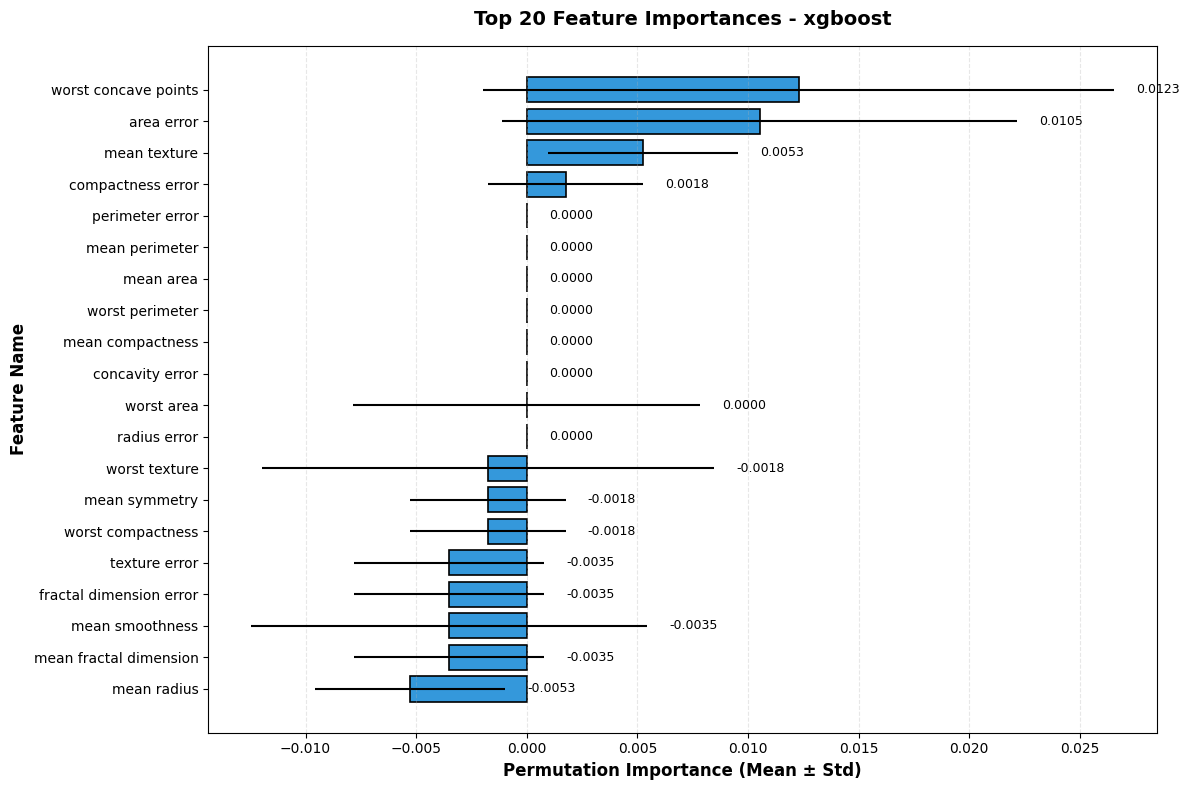


💡 特征重要性解读:

1️⃣  最重要特征: worst concave points
   重要性: 0.0123
   → 这个特征对模型预测影响最大

2️⃣  次重要特征: area error
   重要性: 0.0105

3️⃣  第三重要特征: mean texture
   重要性: 0.0053

🎯 从特征重要性中学习:
   1. 哪类特征最有价值? (如: worst 系列 vs mean 系列)
   2. 哪些特征可以忽略? (importance 接近 0)
   3. 特征工程方向: 可以创造更多类似重要特征的衍生特征

✅ 特征重要性分析完成!


In [11]:
# ==================== 4.1 特征重要性分析 ====================
#
# 📚 为什么要分析特征重要性?
#
# **对于学习者**:
# - 理解哪些特征对模型预测最关键
# - 学习特征工程的思路 (哪类特征更有价值)
# - 为手动建模提供指导
#
# **对于实践者**:
# - 特征选择: 移除不重要的特征,简化模型
# - 数据收集: 优先收集重要特征的数据
# - 可解释性: 向业务人员解释模型依据
#
# 💡 获取特征重要性的方法:
#
# 1. **模型内置方法** (仅部分模型支持):
#    - 树模型 (XGBoost、RF): feature_importances_
#    - 线性模型 (LR): coef_
#
# 2. **Permutation Importance** (所有模型适用):
#    - 原理: 打乱某个特征的值,观察性能下降
#    - 下降越多 → 该特征越重要
#    - 优点: 适用所有模型,考虑特征交互
#
# 3. **SHAP 值** (最推荐,但需额外安装):
#    - 基于博弈论的特征贡献度
#    - 可以解释单个样本的预测
#    - 需要: pip install shap
#
# 🎯 本示例使用: Permutation Importance
# 原因: 适用所有模型,无需额外依赖

from sklearn.inspection import permutation_importance

# 获取最佳模型对象
best_model_obj = automl.model

print("=" * 70)
print("🔍 特征重要性分析")
print("=" * 70)
print(f"\n当前最佳模型: {automl.best_estimator}")
print(f"特征数量: {X_train.shape[1]}")
print("\n📊 使用 Permutation Importance 计算特征重要性...")
print("   (打乱某特征后,性能下降越多,该特征越重要)\n")

# 计算 Permutation Importance
# - n_repeats=5: 每个特征打乱5次,取平均值
# - random_state=42: 保证可复现
perm_importance = permutation_importance(
    best_model_obj,
    X_test,  # 在测试集上评估
    y_test,
    n_repeats=5,
    random_state=42,
    n_jobs=-1
)

# 获取特征名称 (乳腺癌数据集的特征名)
from sklearn.datasets import load_breast_cancer
feature_names = load_breast_cancer().feature_names

# 创建特征重要性 DataFrame
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance_mean': perm_importance.importances_mean,
    'importance_std': perm_importance.importances_std
}).sort_values('importance_mean', ascending=False)

# 显示前15个最重要的特征
print("\n" + "=" * 70)
print("📊 Top 15 最重要特征:")
print("=" * 70)
print(importance_df.head(15).to_string(index=False))

# 可视化特征重要性
plt.figure(figsize=(12, 8))

# 选择前20个特征
top_n = 20
top_features = importance_df.head(top_n)

# 创建水平条形图
bars = plt.barh(
    range(top_n),
    top_features['importance_mean'],
    xerr=top_features['importance_std'],  # 添加误差棒
    color='#3498db',
    edgecolor='black',
    linewidth=1.2
)

# 设置y轴标签
plt.yticks(range(top_n), top_features['feature'], fontsize=10)

# 添加数值标签
for i, (mean, std) in enumerate(zip(top_features['importance_mean'], top_features['importance_std'])):
    plt.text(mean + std + 0.001, i, f'{mean:.4f}', 
             va='center', fontsize=9)

plt.xlabel('Permutation Importance (Mean ± Std)', fontsize=12, fontweight='bold')
plt.ylabel('Feature Name', fontsize=12, fontweight='bold')
plt.title(f'Top {top_n} Feature Importances - {automl.best_estimator}', 
          fontsize=14, fontweight='bold', pad=15)
plt.grid(axis='x', alpha=0.3, linestyle='--')
plt.gca().invert_yaxis()  # 最重要的在顶部

plt.tight_layout()
plt.show()

# 分析和解释
print("\n" + "=" * 70)
print("💡 特征重要性解读:")
print("=" * 70)
print(f"\n1️⃣  最重要特征: {importance_df.iloc[0]['feature']}")
print(f"   重要性: {importance_df.iloc[0]['importance_mean']:.4f}")
print("   → 这个特征对模型预测影响最大")

print(f"\n2️⃣  次重要特征: {importance_df.iloc[1]['feature']}")
print(f"   重要性: {importance_df.iloc[1]['importance_mean']:.4f}")

print(f"\n3️⃣  第三重要特征: {importance_df.iloc[2]['feature']}")
print(f"   重要性: {importance_df.iloc[2]['importance_mean']:.4f}")

print("\n🎯 从特征重要性中学习:")
print("   1. 哪类特征最有价值? (如: worst 系列 vs mean 系列)")
print("   2. 哪些特征可以忽略? (importance 接近 0)")
print("   3. 特征工程方向: 可以创造更多类似重要特征的衍生特征")

print("\n✅ 特征重要性分析完成!")

---

## 📚 从 FLAML 学习: 深度分析篇

> 💡 **这是本节的核心内容！**
>
> AutoML 不仅能帮我们训练模型,更重要的是:
> **从 AutoML 的决策中学习机器学习的最佳实践**
>
> 本章将深入分析 FLAML 的选择,包括:
> - ✅ 特征工程分析 (哪些特征最重要)
> - ✅ 模型选择分析 (为什么选这个模型)
> - ✅ 超参数分析 (最优参数的含义)
> - ✅ 优化过程可视化 (CFO 的搜索轨迹)

---

### 4.1 特征重要性分析

**学习目标**:
- 理解哪些特征对预测最重要
- 学习如何解读特征重要性
- 从特征重要性中获得特征工程的灵感

In [13]:
# 对比：不同时间预算的效果
time_budgets = [30, 60, 120, 300]
results = []

for budget in time_budgets:
    automl_temp = AutoML()
    
    start = time.time()
    automl_temp.fit(
        X_train, y_train,
        task='classification',
        time_budget=budget,
        metric='accuracy',
        verbose=0,
        seed=42
    )
    actual_time = time.time() - start
    
    accuracy = accuracy_score(y_test, automl_temp.predict(X_test))
    
    results.append({
        'time_budget': budget,
        'actual_time': actual_time,
        'accuracy': accuracy,
        'best_model': automl_temp.best_estimator
    })

# 展示结果
results_df = pd.DataFrame(results)
print("\n时间预算 vs 准确率:")
print(results_df)

KeyboardInterrupt: 

In [ ]:
# 可视化：时间 vs 准确率
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(results_df['time_budget'], results_df['accuracy'], 'o-')
plt.xlabel('Time Budget (seconds)')
plt.ylabel('Accuracy')
plt.title('Time Budget vs Accuracy')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(results_df['actual_time'], results_df['accuracy'], 's-', color='orange')
plt.xlabel('Actual Time (seconds)')
plt.ylabel('Accuracy')
plt.title('Actual Time vs Accuracy')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

## 5. 高级配置

### 5.1 限制模型类型

In [ ]:
# 只使用树模型
automl_trees = AutoML()
automl_trees.fit(
    X_train, y_train,
    task='classification',
    time_budget=60,
    estimator_list=['xgboost', 'rf', 'lgbm'],  # 限制模型类型
    seed=42
)

print(f"最佳模型: {automl_trees.best_estimator}")
print(f"准确率: {accuracy_score(y_test, automl_trees.predict(X_test)):.4f}")

### 5.2 自定义评估指标

In [ ]:
from sklearn.metrics import f1_score, make_scorer

# 自定义指标函数
def custom_metric(y_true, y_pred):
    return f1_score(y_true, y_pred, average='weighted')

# 使用自定义指标
automl_custom = AutoML()
automl_custom.fit(
    X_train, y_train,
    task='classification',
    time_budget=60,
    metric=custom_metric,
    seed=42
)

print(f"\n最佳F1 Score: {automl_custom.best_loss:.4f}")

### 5.3 早停策略

In [ ]:
# 设置早停：如果性能不再提升，提前结束
automl_early = AutoML()
automl_early.fit(
    X_train, y_train,
    task='classification',
    time_budget=300,
    early_stop=True,               # 启用早停
    seed=42
)

print("✅ 使用早停策略训练完成")

### 5.4 交叉验证设置

In [ ]:
# 自定义交叉验证折数
automl_cv = AutoML()
automl_cv.fit(
    X_train, y_train,
    task='classification',
    time_budget=60,
    n_splits=10,  # 10折交叉验证
    seed=42
)

print(f"使用 {automl_cv.best_config_per_estimator} 折交叉验证")

---

## 6. FLAML vs 其他 AutoML 工具对比

### 6.1 速度对比

In [ ]:
# 对比 FLAML 和 sklearn GridSearch 的速度
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# FLAML
start = time.time()
automl_fast = AutoML()
automl_fast.fit(X_train, y_train, task='classification', time_budget=60, seed=42)
flaml_time = time.time() - start
flaml_acc = accuracy_score(y_test, automl_fast.predict(X_test))

# sklearn GridSearchCV
start = time.time()
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10]
}
grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5)
grid.fit(X_train, y_train)
grid_time = time.time() - start
grid_acc = accuracy_score(y_test, grid.predict(X_test))

# 对比结果
print("\n速度对比:")
print(f"FLAML:       {flaml_time:.2f}秒, 准确率: {flaml_acc:.4f}")
print(f"GridSearch:  {grid_time:.2f}秒, 准确率: {grid_acc:.4f}")
print(f"\nFLAML 速度提升: {grid_time/flaml_time:.2f}x")

---

## 7. 大数据集优化技巧

### 7.1 使用采样策略

In [ ]:
# 对于大数据集，FLAML 会自动采样
automl_large = AutoML()
automl_large.fit(
    X_train, y_train,
    task='classification',
    time_budget=60,
    max_iter=None,           # 不限制迭代次数
    sample=True,             # 启用采样
    seed=42
)

print("✅ 大数据集优化完成")

### 7.2 使用增量学习

In [ ]:
---

## 9. 总结与最佳实践

### 📚 FLAML 核心知识点回顾

#### 1. CFO 算法 (Cost-Frugal Optimization)

**核心思想**:
- 不仅追求性能,还考虑训练成本
- 性价比 = 性能提升 / 训练成本
- 低成本配置优先,智能资源分配

**三大机制**:
- ✅ 低成本优先: 快速验证多个模型
- ✅ 早停策略: 避免浪费时间
- ✅ 动态分配: 根据已有结果调整搜索策略

**优势**:
- 速度快: 比传统 AutoML 快 10-100 倍
- 效率高: 在有限时间内找到更好配置
- 适应性强: 支持 30秒 到 1小时的不同预算

---

#### 2. 使用 FLAML 的完整工作流

```python
# 步骤1: 导入库
from flaml import AutoML

# 步骤2: 创建 AutoML 对象
automl = AutoML()

# 步骤3: 训练 (核心步骤)
automl.fit(
    X_train, y_train,
    task='classification',      # 或 'regression'
    time_budget=60,             # 时间预算 (秒)
    metric='accuracy',          # 优化指标
    log_file_name='flaml.log',  # 日志文件
    seed=42
)

# 步骤4: 查看结果
print(f"最佳模型: {automl.best_estimator}")
print(f"最佳配置: {automl.best_config}")

# 步骤5: 预测
y_pred = automl.predict(X_test)

# 步骤6: 从 FLAML 学习
# - 分析特征重要性
# - 理解模型选择原因
# - 学习最优超参数
```

---

### 🎯 从 FLAML 学习的四大要点

#### 1️⃣ 特征工程

- 查看特征重要性排序
- 理解哪类特征最有价值
- 学习特征选择和衍生的思路

#### 2️⃣ 模型选择

- 分析 FLAML 尝试了哪些模型
- 理解为什么选择某个模型
- 学习数据特征与模型适用性的关系

#### 3️⃣ 超参数调优

- 查看最优超参数配置
- 理解各参数的含义和影响
- 学习超参数调优的策略

#### 4️⃣ 优化策略

- 观察 CFO 的搜索轨迹
- 理解性价比权衡
- 学习智能搜索的思路

---

### 💡 FLAML 使用最佳实践

#### 时间预算设置

| 场景 | 推荐时间 | 说明 |
|------|---------|------|
| 快速验证 | 30-60s | 初步探索,快速获得 baseline |
| 标准训练 | 300-600s | 正式项目,平衡速度和性能 |
| 深度搜索 | 1800-3600s | 竞赛冲榜,追求极致性能 |

#### 指标选择

**分类任务**:
- 类别平衡 → `metric='accuracy'`
- 类别不平衡 → `metric='roc_auc'` 或 `'f1'`
- 概率预测 → `metric='log_loss'`

**回归任务**:
- 一般情况 → `metric='r2'`
- 关注绝对误差 → `metric='mae'`
- 关注平方误差 → `metric='rmse'`

#### 模型选择

**限制模型类型** (加速搜索):
```python
automl.fit(
    ...,
    estimator_list=['xgboost', 'lgbm', 'rf']  # 只使用树模型
)
```

**排除某些模型**:
```python
automl.fit(
    ...,
    estimator_list='auto',
    skip_estimator_list=['kneighbor']  # 跳过 KNN
)
```

---

### ⚠️ 常见陷阱与注意事项

#### 1️⃣ 时间预算陷阱

❌ **错误做法**:
```python
# 时间太短,搜索不充分
automl.fit(..., time_budget=10)  
```

✅ **正确做法**:
```python
# 至少给 30-60 秒
automl.fit(..., time_budget=60)
```

#### 2️⃣ 盲目信任 AutoML

❌ **错误做法**:
- 不分析特征重要性
- 不理解模型选择原因
- 直接部署到生产

✅ **正确做法**:
- 分析 FLAML 的决策
- 验证结果是否合理
- 结合领域知识调整

#### 3️⃣ 忽略数据预处理

❌ **错误做法**:
- 直接把原始数据喂给 FLAML
- 不处理缺失值和异常值

✅ **正确做法**:
- 先进行基础的数据清洗
- FLAML 会自动标准化,但不会处理缺失值

---

### 🏆 FLAML vs 其他 AutoML 工具

| 工具 | 速度 | 易用性 | 功能 | 推荐场景 |
|------|-----|--------|------|---------|
| **FLAML** | ⭐⭐⭐⭐⭐ | ⭐⭐⭐⭐ | ⭐⭐⭐⭐ | 快速baseline,大数据集,低成本 |
| **PyCaret** | ⭐⭐⭐⭐ | ⭐⭐⭐⭐⭐ | ⭐⭐⭐⭐⭐ | 初学者,快速原型,可视化丰富 |
| **Auto-sklearn** | ⭐⭐⭐ | ⭐⭐⭐ | ⭐⭐⭐⭐ | sklearn用户,Linux环境 |
| **H2O AutoML** | ⭐⭐⭐⭐⭐ | ⭐⭐⭐ | ⭐⭐⭐⭐⭐ | 企业级,生产环境,大数据 |

**选择建议**:
- 🚀 追求速度 → **FLAML**
- 🎓 学习/教学 → **PyCaret**
- 🏢 生产部署 → **H2O AutoML**

---

### 🎯 学习建议

#### 对于初学者:

1. **先用起来**: 快速上手 FLAML,体验 AutoML 的威力
2. **对比学习**: 将 FLAML 结果与手动调参对比
3. **深入理解**: 学习 CFO 算法原理,理解为什么快
4. **实践应用**: 在多个数据集上实验,总结规律

#### 对于进阶用户:

1. **分析日志**: 深入研究 `flaml.log`,理解搜索过程
2. **参数调优**: 尝试不同的 `time_budget`,找到最优平衡点
3. **特征工程**: 基于特征重要性,手动创造新特征
4. **模型融合**: 结合 FLAML 和手动模型,提升性能

---

## 🎯 练习任务

### 任务 1: 基础应用 (必做)

使用 FLAML 在 sklearn 的 Iris 数据集上完成分类任务:
- 设置 time_budget=30
- 分析最佳模型和超参数
- 计算测试集准确率

### 任务 2: 时间预算实验

在同一数据集上,对比不同时间预算的效果:
- time_budget = [30, 60, 120, 300]
- 绘制时间 vs 准确率曲线
- 找到"性价比"最高的时间设置

### 任务 3: 特征重要性分析 (重点)

- 使用 Permutation Importance 分析特征重要性
- 找出 Top 5 最重要特征
- 尝试只用这 5 个特征重新训练,对比性能

### 任务 4: 与 PyCaret 对比

在同一数据集上:
- 使用 FLAML (time_budget=120)
- 使用 PyCaret (compare_models + tune_model)
- 对比速度和准确率

### 任务 5: 真实数据集挑战

在 Kaggle 的 Titanic 数据集上:
- 使用 FLAML 建立 baseline
- 分析特征重要性
- 手动特征工程后再训练
- 对比 AutoML vs 手动的效果

---

## 📚 参考资源

### 官方资源
- [FLAML 官方文档](https://microsoft.github.io/FLAML/)
- [FLAML GitHub](https://github.com/microsoft/FLAML)
- [CFO 算法论文](https://arxiv.org/abs/1911.04706)

### 扩展阅读
- [AutoML 综述论文](https://arxiv.org/abs/1908.00709)
- [超参数优化方法对比](https://arxiv.org/abs/1807.02811)

---

**下一步学习**: 
- 深度学习 AutoML (如 Auto-Keras)
- 特征工程自动化
- 模型解释与可解释性

**建议学习时间**: 本教程 2-3 小时 (理论 + 实践)

---

✅ **恭喜完成 FLAML 教程！你已经掌握了微软最强 AutoML 工具！**

---

## 8. 模型保存与部署

In [ ]:
import pickle

# 保存模型
with open('flaml_model.pkl', 'wb') as f:
    pickle.dump(automl, f)

# 加载模型
with open('flaml_model.pkl', 'rb') as f:
    loaded_automl = pickle.load(f)

# 预测
predictions = loaded_automl.predict(X_test)

print("✅ 模型保存和加载成功")
print(f"加载后准确率: {accuracy_score(y_test, predictions):.4f}")

---

## 9. 总结与最佳实践

### FLAML 核心优势

1. **速度**: 成本敏感优化，快速找到好模型
2. **效率**: 低计算成本，适合预算有限场景
3. **可扩展**: 支持大数据集
4. **工业级**: 微软生产环境验证

### 使用场景

```python
# 快速验证（1分钟）
automl.fit(..., time_budget=60)

# 标准训练（5-10分钟）
automl.fit(..., time_budget=300)

# 深度搜索（30分钟-1小时）
automl.fit(..., time_budget=3600)
```

### 最佳实践

1. **时间预算**: 根据项目时间合理设置
2. **模型选择**: 限制模型类型可以加速搜索
3. **早停**: 对于简单任务，启用早停节省时间
4. **大数据集**: 使用采样策略
5. **日志分析**: 查看 `flaml.log` 了解搜索过程

### 优势与局限

**优势**：
- ✅ 速度最快
- ✅ 成本最低
- ✅ 大数据友好

**局限**：
- ❌ 功能不如PyCaret丰富
- ❌ 可视化较少
- ❌ 集成功能有限

---

## 🎯 练习任务

1. **任务1**: 对比不同时间预算下的性能
2. **任务2**: 理解成本敏感优化的原理
3. **任务3**: 在大数据集上测试FLAML
4. **任务4**: 对比FLAML和PyCaret的效果

---

## 📚 参考资源

- [FLAML 官方文档](https://microsoft.github.io/FLAML/)
- [FLAML 论文](https://arxiv.org/abs/1911.04706)
- [微软研究院博客](https://www.microsoft.com/en-us/research/project/fast-and-lightweight-automl/)

---

**下一节**: `04_h2o_automl.ipynb` - H2O AutoML 企业级应用